# Building Explainable Machine Learning Models
## Exercise: Interpreting models with SHAP

* SHAP stands for SHapley Additive exPlanations.
* It leverages the concept of game theory to break down a prediction to measure the impact of each feature.
* Shap displays the effect of the feature at on prediction at a certain value than if the feature was at a baseline value.


During this exercise,  you are going to be working with SHAP (SHapley Additive exPlanations)by working on a credit card dataset. You'll perform the following steps:

* Train a LightGBM model on the given dataset.
* Compute the Shapley values  to explain the individual feature contributions.
* Visualize these values and interpret them.


Let's get started!

---

## Case Study: Who will default on a Credit Card Payment?

The objective of the problem is to predict which customers are going to default on their credit card payments i.e credible or not credible clients

![](https://imgur.com/my7jtQQ.png)




## Importing Necessary Libraries

Let’s start by importing the necessary libraries.

In [1]:
%pip install shap -qq
%pip install numpy==1.20 # Numba requires numpy 1.21 or less


import numpy as np   
import pandas as pd  

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Machine learning packages
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline


np.random.seed(123) #ensure reproducibility
RANDOM_STATE = 42

## Model Interpretation package
import shap
shap.initjs()

import warnings  
warnings.filterwarnings(action = "ignore")

In [2]:
# setting up the styling for the plots in this notebook
sns.set(style="white", palette="colorblind", font_scale=1.2, 
        rc={"figure.figsize":(10,6)})

##  Reading in the Dataset

This dataset contains information about credit card clients in Taiwan from April 2005 to September 2005. Features include demographic factors, repayment statuses, history of payment, bill statements, and default payments.The data set comes from the  [UCI Machine Learning Repository Irvine, CA: University of California, School of Information and Computer Science](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients#). The objective of the dataset is to predict which customers will churn the credit card services of a bank.

*Since the main aim of this exervise is to demonstrate the working of the SHAP package, a preprocessed version of the dataset has been provided for the exercise. However you are encouraged to work through the original dataset also after the session.*

Let’s read in the data and look at the first few rows

In [3]:
data = pd.read_csv('../data/UCI_Credit_Card.csv')
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0



-   **`LIMIT_BAL`**: Amount of given credit (NT dollar)
-   **`SEX`**: 1 = male; 2 = female
-   **`EDUCATION`**: 1 = graduate school; 2 = university; 3 = high school; 4 = others
-   **`MARRIAGE`**: 1 = married; 2 = single; 3 = others
-   **`AGE`**: Age in years
-   **`PAY_0`,  `PAY_2`  -  `PAY_6`**: History of past payment;  `PAY_0`  = the repayment status in September, 2005;  `PAY_2`  = the repayment status in August, 2005; ...;  `PAY_6`  = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; ...; 8 = payment delay for eight months; 9 = payment delay for nine months and above.
-   **`BILL_AMT1`  -  `BILL_AMT6`**: Amount of bill statement (NT dollar).  `BILL_AMNT1`  = amount of bill statement in September, 2005;  `BILL_AMT2`  = amount of bill statement in August, 2005; ...;  `BILL_AMT6`  = amount of bill statement in April, 2005.
-   **`PAY_AMT1`  -  `PAY_AMT6`**: Amount of previous payment (NT dollar).  `PAY_AMT1`  = amount paid in September, 2005;  `PAY_AMT2`  = amount paid in August, 2005; ...;  `PAY_AMT6`  = amount paid in April, 2005.
-   **`default.payment.next.month`**: Default payment (1=yes, 0=no)

As can be seen, the dataset consists of various predictor variables like age, sex, Limit balance, etc, and one target variable called `default.pament.next.month`. The target variable is 1 if the customer defaults on payment and 0, if the payment is done on time. It is a classic binary classification problem. Also, let's check out if there are any missing values in the dataset.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-null  int64
 14  BILL_A

## Data Preparation 

### Removing Demographic features


Demographic features are not used as model inputs.

In [5]:

target = 'default payment next month'

predictors = [name for name in data.columns if name not in [target,'ID', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE']]

print('target =', target )
print('predictors =', predictors)  



target = default payment next month
predictors = ['LIMIT_BAL', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


### Train/Test Split
Creating the target and the features column and splitting the dataset into train and validation sets. 

In [6]:
# splitting the dataset into training and validation set
X_train, X_val, y_train, y_val = train_test_split(data[predictors], data[target], test_size = 0.3, random_state=RANDOM_STATE)


## Training a Random Forest Model

Now you will fit a [Random Forest classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) with 20 estimators and compute the [AUC](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html) achieved:

In [7]:
model_rf = RandomForestClassifier(max_depth=6, random_state=0, n_estimators=20)
model_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=6, n_estimators=20, random_state=0)

### Making predictions on the test set

In [8]:

# Making predictions on the test set
y_pred = model_rf.predict_proba(X_val)[:, 1]


# Print the AUC score achieved by the classifier on the test set
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
auc(fpr, tpr)


0.7704991883116883

### Displaying Random Forests' Feature Importance

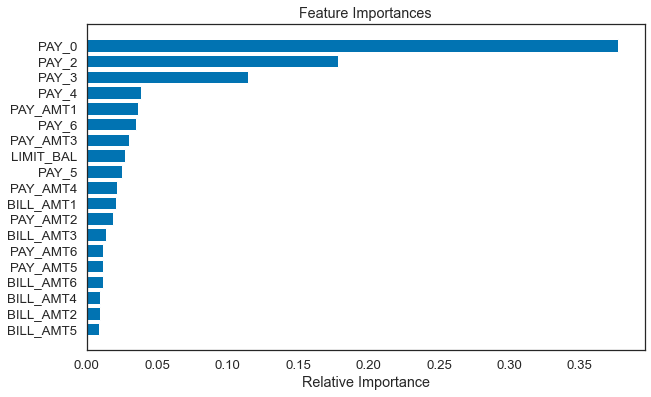

In [9]:
importances = model_rf.feature_importances_
indices = np.argsort(importances)
features = X_train.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

We now have our model and our predictions. Let’s now explore the different ways by which we can understand the model and its predictions in a more meaningful way.

---

## Calculating SHAP values



![](https://imgur.com/qPBkX1r.png)

source: [Documentation of SHAP](https://github.com/slundberg/shap)

To get the importance of feature X<sub>i</sub>:

* Get all subsets of features that do not contain X<sub>i</sub>
* Compute effect on our predictions of adding X<sub>i</sub> to all those subsets
* Aggregate all contributions to compute the marginal contribution of the feature

### SHAP Tree explainer

To compute shap values for the model you just trained you will use the [TreeExplainer](https://shap-lrjball.readthedocs.io/en/docs_update/generated/shap.TreeExplainer.html) class from the `shap` library. A SHAP tree explainer is a high-speed exact algorithm for tree ensemble methods that supports XGBoost, LightGBM, CatBoost, scikit-learn and pyspark tree models. To instantiate this class you need to pass in a model.

In [10]:
explainer = shap.TreeExplainer(model=model_rf)
shap_values = explainer.shap_values(X_val[predictors],check_additivity=False)
pd.DataFrame(shap_values[1]).head()





,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.027882,-0.038230,-0.019421,-0.012593,-0.005160,-0.002778,-0.004646,-0.001440,-0.000257,0.001233,0.000119,-0.000287,-0.000651,0.001484,-0.001750,-0.002011,0.001988,-0.001006,-0.002028
1,-0.010703,-0.037038,-0.020457,-0.012269,-0.005920,-0.002468,-0.004698,-0.001154,-0.000795,-0.000185,-0.000777,0.000187,0.000344,-0.004027,-0.004492,-0.012787,-0.006697,-0.002384,-0.004433
2,0.015860,-0.039899,-0.019875,-0.013293,-0.005305,-0.002913,-0.004293,-0.001132,-0.001102,0.000206,-0.000137,-0.001598,0.000381,-0.001944,-0.002441,-0.010650,-0.010365,-0.001870,-0.002716
3,-0.007182,-0.038404,-0.019877,-0.011059,-0.005731,-0.002691,-0.005403,-0.002025,-0.001683,0.000296,-0.000816,-0.000582,-0.001616,0.000074,-0.003404,-0.013593,0.004113,-0.002527,-0.005337
4,0.013542,-0.040911,-0.023585,-0.012377,-0.007003,-0.004260,0.042237,-0.001595,-0.001081,0.000521,-0.000634,-0.000690,0.001375,-0.000882,0.000651,-0.003740,-0.002716,0.000346,0.007107


* We get a matrix of SHAP values. These values measure how and how much each feature impacts the model.

> For classification problems, `explainer.shap_values()` return a list of size `n_classes`. Since this is a binary classification model n_classes=2, each object of this list is an array of size [n_samples, n_features] and corresponds to the SHAP values for the respective class. In this example, `shap_values[1]` is the SHAP values for the positive class (default payment next month = Yes) & `shap_values[0]` is the SHAP values for the negative class. For regression models, we get a single set of shap values of size [n_samples, n_features].



Tree SHAP provides us with several different types of plots, each one highlighting a specific aspect of the model. The available plots are:
* Summary plot
* Force plot
* Dependence plot
* Decision plot

### Force Plot

Let's explain the model's prediction for tenth item in the validation set.

In [15]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][50,:], features=X_val[predictors].iloc[10, :])

### Summary plot

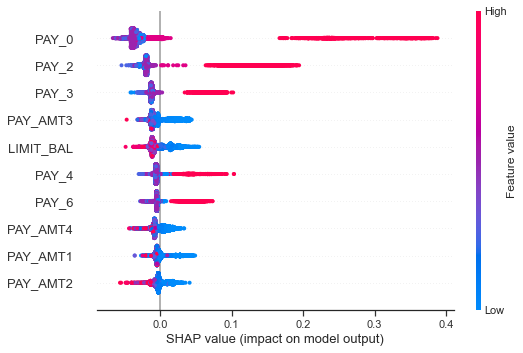

In [12]:
shap.summary_plot(shap_values[1], features=X_val[predictors], max_display=10)

* The y-axis indicates the variable name, in order of importance from top to bottom. 
* On the x-axis is the SHAP value indicating the change in log-odds. From this number we can extract the probability of success.
* Color shows whether that feature was high (RED Color) or low (BLUE Color) for any row of the dataset
* Each point represents a row from the original dataset.Horizontal location of dots shows whether the effect of that value caused a higher or lower prediction. Negative shapley value will reduce the prediction probability and Positive shapley will increase prediction probability.




### References

[1] https://en.wikipedia.org/wiki/Shapley_value

[2] https://github.com/slundberg/shap

[3] C. Molnar, [Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book), 

---